## 0. Importe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TODO: Importiere Decision Tree aus Scikit-Learn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# TODO: Importiere Random Forest aus Scikit-Learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# TODO: Importiere Gradient Boosting aus Scikit-Learn
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# TODO: Importiere Evaluationsmetriken
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# TODO: Visualisierungstools
from sklearn.tree import plot_tree

# TODO: Importieren von `train_test_split`
from sklearn.model_selection import train_test_split

import utils_viz

## 1. Decision Trees

Decision Trees sind überwachte Lernmodelle, die sich sowohl für Klassifikationsprobleme (die Zielvariable ist ein diskreter/kategorieller Wert) als auch für Regressionsprobleme (die Zielvariable ist ein metrischer Wert) eignen.

Wir benutzen für dieses Tutorial die in Scikit-Learn implementierten Klassen für Decision Trees: `DecisionTreeClassifier` und `DecisionTreeRegressor`. Achten Sie in jedem Fall darauf, die für das Problem passende Klasse zu verwenden.

Nach dem Import der Klassen reicht ein Blick in den Docstring der Klassen, das heißt durch

```python
>>> DecisionTreeClassifier?
```

um zu erkennen, dass bei der Initialisierung des Decision Trees viele Argumente übergeben werden können. Wir beschränken uns hier nur auf das wichtigste davon, nämlich `max_depth`.

Weitere relevante Funktionen und Attribute sind
- `fit`
- `predict`

sowie fortgeschrittene Attribute:
- `predict_proba`
- `feature_importances_` (erst nach dem Fit verfügbar)

### 1.1 Decision Trees für Klassifikation

Zunächst beschäftigen wir uns mit dem Einlesen und Vorbereiten eines Toy-Datensatzes. Der Datensatz soll den Zusammenhang zwischen zwei Features, die die Genaktivität zweier Gene einer nicht genannten Spezies (Beispiel: Mäuse) und dem Phänotyp dieser Spezies darstellen. Es gibt 4 verschiedene Phänotypen (A, B, C, D) - es handelt sich also um ein Klassifikationsproblem. Decision Trees können auf natürliche Weise solche Multi-Class-Klassifikationen handhaben (tatsächlich können das alle Modelle in Scikit-Learn, aber nur weil intern dazu eine gewisse zusätzliche Logik - genannt One-vs-All - verbaut ist. Decision Trees handhaben Multi-Class ganz selbstständig.)

Wir müssen

- die Daten einlesen
- die Phänotypen A, B, C, D in numerische Werte übersetzen
- die Daten in Trainings- und Testdaten aufspalten
- die Daten in einem Scatterplot visualisieren

In [2]:
# TODO: Einlesen der Daten `toy_gene_data.csv`
data = pd.read_csv("../data/toy_gene_data.csv")

# TODO: Daten verarbeiten
print(data["Phänotyp"].value_counts())

data["Phänotyp"] = data["Phänotyp"].replace({"A": 0, "B": 1, "C": 2, "D": 3})

data

C    100
D    100
B    100
A    100
Name: Phänotyp, dtype: int64


,Genaktivität X,Genaktivität Y,Phänotyp
0,1.248945,5.590138,3
1,-3.478708,2.257991,2
2,-3.815524,3.169367,2
3,0.520738,4.321266,0
4,-3.208122,2.028911,2
...,...,...,...
395,-0.249165,5.148150,0
396,-0.057973,4.985382,0
397,0.631207,0.404344,1
398,1.169320,2.843958,2


In [3]:
# TODO: Aufspalten der Daten in Trainings- und Testdaten
X = data.iloc[:, 0:2].values
y = data.iloc[:, 2].values

# Option 1 (nur möglich, wenn die Klassen nicht sortiert sind)
X_train = X[:300, :]
y_train = y[:300]

X_test = X[300:, :]
y_test = y[300:]


# Option 2 - Scikit-Learn
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

[Text(1, 0.5, 'A'), Text(1, 1.0, 'B'), Text(1, 2.0, 'C'), Text(1, 2.5, 'D')]

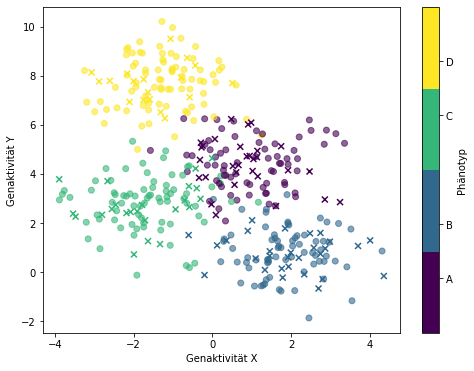

In [4]:
# TODO: Visualisieren der Daten
cmap = plt.get_cmap('viridis', 4)

plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, marker="x")
plt.xlabel("Genaktivität X")
plt.ylabel("Genaktivität Y")

cbar = plt.colorbar(label="Phänotyp", ticks=[0.5, 1, 2, 2.5])
cbar.ax.set_yticklabels(["A", "B", "C", "D"])

Nun fitten wir das Modell auf die übliche Weise und evaluieren. Wir nutzen die **Genauigkeit** bzw. *Korrekte-Klassifikations-Rate* als Metrik zum Evaluieren, da wir es mit einem Klassifikationsproblem zu tun haben. Wir können dafür eine Funktion schreiben oder die Funktion `accuracy_score` aus Scikit-Learn importieren.

Dabei sollten wir auch das Argument `max_depth` variieren und verstehen, welchen Einfluss dieses auf den Trainingsfehler bzw. Testfehler hat (Overfitting versus Underfitting?).

Beim Training des Decision Trees ist folgendes relevant:
- der Decision Tree versucht beim Aufspalten der Daten in jedem Knoten den **Gini-Koeffizienten** (alternativ die **Entropie**) in den nachfolgenden Knoten zu minimieren.
- die Vorhersage in den Blättern ist die häufigste Klasse unter den Trainingsdatenpunkten, die in diesem Blatt gelandet sind.
- das Aufspalten in jedem Knoten ist *greedy*, das heißt es wird so gespalten, wie es zu jedem Zeitpunkt am sinnvollsten erscheint, ohne auf den weiteren Verlauf des Baums zu achten.
- die Größe des Baums ist vor allem von `max_depth` abhängig. Daneben gibt es andere Abbruchkriterien für das Wachsen des Baums, die durch weitere Argumente bei der Initialisierung eingestellt werden können. In jedem endet das Wachstum, wenn in einem Blatt alle Trainingsdatenpunkte derselben Klasse angehören.

Weiterhin gibt es die Möglichkeit, die Entscheidungen des trainierten Baums zu visualisieren. Dazu existiert eine Funktion `plot_tree` in Scikit-Learn. Als zusätzliche Visualisierung werden wir auch die Entscheidungsgrenzen des Modells veranschaulichen, was wir dank der Benutzung von nur zwei Features problemlos können.

In [5]:
# TODO: Modell trainieren
tree = DecisionTreeClassifier(max_depth=1, criterion="gini")
tree.fit(X_train, y_train)

# TODO: Modell evaluieren
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(accuracy_train)
print(accuracy_test)

0.52
0.41


Text(0, 0.5, 'Genaktivität Y')

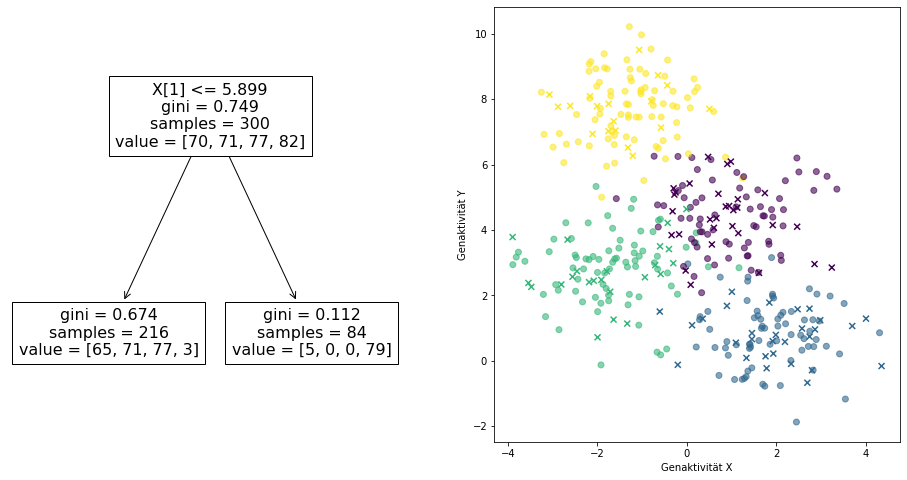

In [6]:
# TODO: Modell visualisieren
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plot_tree(tree);

plt.subplot(1, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, marker="x")
plt.xlabel("Genaktivität X")
plt.ylabel("Genaktivität Y")


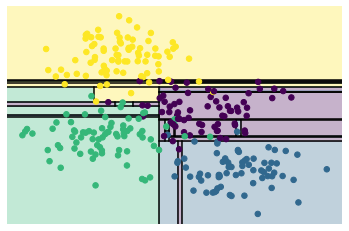

In [7]:
tree = DecisionTreeClassifier(max_depth=10)

utils_viz.visualize_tree(tree, X_train, y_train)

### 1.2 Decision Trees für Regressionen

Durch leichte Änderungen das Algorithmus können Decision Trees auch für Regressionsprobleme verwendet werden.
Wir untersuchen ein Regressionsproblem, das nur auf einem Feature beruht, damit für wie gehabt den Fit in einem Graphen visualisieren können. Wir entscheiden uns für den Toy-Automobile Datensatz.

Folgende Unterschiede sind bei einem Decision Tree für Regressionen im Vergleich zu einem für Klassifikationen zu beachten:
- der Regressions-Decision Tree versucht nicht den **Gini-Koeffizienten** (oder alternativ die **Entropie**) der Knoten zu minimieren, sondern minimiert den **Mean-Squared-Error** der Knoten.
- die Vorhersage an einem Blatt ist nicht die häufigste Klasse, sondern der durchschnittliche Werte der Zielvariablen aller Trainingsdatenpunkte in diesem Blatt
- das Abbruchkriterium für das Wachsen des Baums ist wieder von `max_depth` sowie von weiteren Argumenten abhängig. Außerdem endet das Wachsum in jedem Fall, wenn der **Mean-Squared-Error** in einem Knoten auf Null sinkt, wenn also alle dortigen Trainingsdatenpunkte denselben Wert der Zielvariablen haben.

In [8]:
# TODO: Einlesen der Daten `toy_auto_data_A.csv` und `toy_auto_data_test.csv`
data = pd.read_csv("../data/toy_automobile/toy_auto_data_A.csv")
test_data = pd.read_csv("../data/toy_automobile/toy_auto_data_test.csv")

X_train = data.iloc[:, [0]].values
y_train = data.iloc[:, 1].values

X_test = test_data.iloc[:, [0]].values
y_test = test_data.iloc[:, 1].values

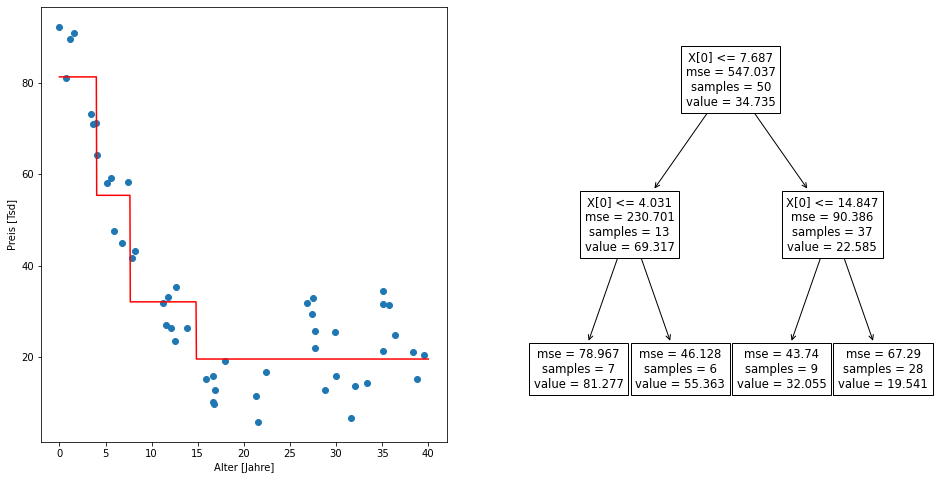

In [9]:
# TODO: Modell trainieren
tree_regressor = DecisionTreeRegressor(max_depth=2)
tree_regressor.fit(X_train, y_train)

plt.figure(figsize=(16, 8))

# TODO: Visualisieren der Daten
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train)

# TODO: Modell visualisieren
x_vis = np.linspace(0, 40, 1000)
y_vis = tree_regressor.predict(x_vis.reshape(-1, 1))
plt.plot(x_vis, y_vis, color="red")
plt.xlabel("Alter [Jahre]")
plt.ylabel("Preis [Tsd]");

plt.subplot(1, 2, 2)
plot_tree(tree_regressor);

In [10]:
# TODO: Modell evaluieren

# Vorhersage
y_pred_train = tree_regressor.predict(X_train)
y_pred_test = tree_regressor.predict(X_test)

# Option 1: MSE
# Vorteile: ist die Metrik, die vom Decision Tree optimiert wird
# Nachteile: schwer interpretierbar
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Option 2: RMSE
# Vorteile: ist fast die Metrik, die vom Decision Tree optimiert wird
#    außerdem interpretierbar
# Nachteile: abhängig von der Maßeinheit der Zielvariablen
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

# oder
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Option 3: r2 - Regressionskoeffizient
# Vorteile: maximal 1.0, für konstantes Modell 0.0 (kann aber negativ werden)
# Nachteile: kann als Genauigkeit missverstanden werden, ist für Fachfremde nicht zu verstehen
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

## 2. Random Forests

Random Forests lösen das wesentliche Problem von Decision Trees: die Tendenz, extremes Overfitting zu betreiben. Dazu besteht der Random Forest aus einer Menge - einem *Ensemble* - von Decision Trees, die sich alle leicht voneinander unterscheiden. Der Vorgang wird auch **Bagging** genannt. Die Decision Trees im *Ensemble* unterscheiden sich dadurch, dass sie jeweils einen leicht anderen Teil der Trainingsdaten kennengelernt haben.

Diese Randomisierung der Trainingsdaten kann auf verschiedene Weise erfolgen:
- zufällige Auswahl von 50-80% der Trainingsdaten für jeden Baum. Überschneidungen zwischen den einzelnen Randomisierungen sind natürlich möglich.
- zufälliges Ziehen-mit-Zurücklegen der Trainingdatenpunkte. Dies wird auch **Bootstrapping** genannt. Es wird einfach wiederholt ein Trainingsdatenpunkt aus den gesamten Trainingsdaten gezogen, dann aber wieder "zurückgelegt", sodass ein Trainingsdatenpunkt in dem neuen, randomisierten Trainingsdatensatz auch mehrmals vorkommen kann.
- Kombinationen aus den beiden vorher genannten Strategien

Zusätzlich kann man für jeden randomisierten Trainingsdatensatz auch eine zufällige Auswahl der Features vornehmen.

Die Argumente bei der Initialisierung des Random Forest erlauben es, alle diese Randomisierungen selbstständig einzustellen. Im einfachsten Fall sollte man es allerdings bei den Default-Werten belassen.

Die wichtigsten Argumente für uns sind deshalb
- `max_depth`
- `n_estimators`

Typische Größen für `n_estimators` sind 100, 200, 500 oder maximal 1000. Danach haben zusätzliche Bäume meist keinen Effekt mehr. `max_depth` muss als Hyperparameter manchmal getunt werden.

Zusätzlich brauchen wir
- `fit`
- `predict`

sowie eventuell fortgeschrittene Attribute:
- `predict_proba`
- `feature_importances_` (erst nach dem Fit verfügbar)

Wichtig ist, dass wir von dem Training der einzelnen Decision Trees nichts mitbekommen, da dies im Aufruf der `fit` und `predict` Funktionen des Random Forest intern geschieht.

### 2.1 Random Forests für Klassifikationen

Wir vergleichen das Ergebnis des Fits zu dem eines einzelnen Decision Trees und versuchen zu verstehen, wie der Random Forest gegen Overfitting arbeitet.

1.0
0.88


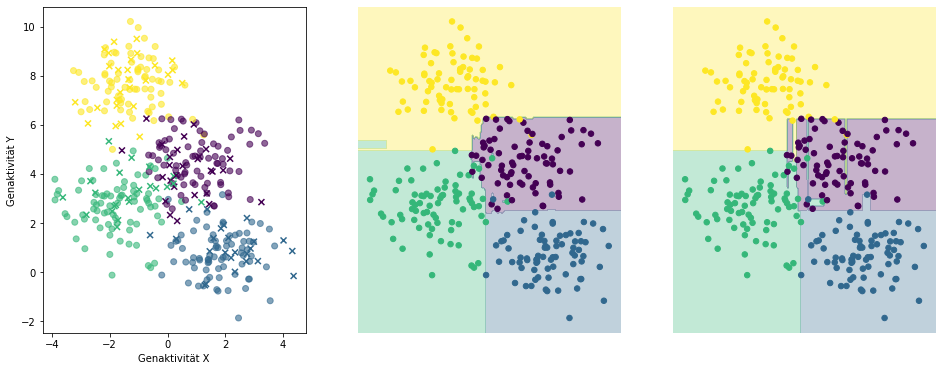

In [11]:
# TODO: Einlesen der Daten `toy_gene_data.csv`
data = pd.read_csv("../data/toy_gene_data.csv")

# TODO: Daten verarbeiten
data["Phänotyp"] = data["Phänotyp"].replace({"A": 0, "B": 1, "C": 2, "D": 3})

# TODO: Aufspalten der Daten in Trainings- und Testdaten
X = data.iloc[:, 0:2].values
y = data.iloc[:, 2].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)


# TODO: Modell trainieren
random_forest = RandomForestClassifier(n_estimators=200)
random_forest.fit(X_train, y_train)

# TODO: Modell evaluieren
y_pred_train = random_forest.predict(X_train)
y_pred_test = random_forest.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(accuracy_train)
print(accuracy_test)


# TODO: Visualisieren der Daten
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, marker="x")
plt.xlabel("Genaktivität X")
plt.ylabel("Genaktivität Y")

plt.subplot(1, 3, 2)
utils_viz.visualize_classifier(random_forest, X_train, y_train, cmap="viridis")

plt.subplot(1, 3, 3)
utils_viz.visualize_classifier(random_forest[10], X_train, y_train, cmap="viridis")

### 2.2. Random für Regressionen

Auch für Regressionsprobleme eignet sich ein Random Forest. Wir vergleichen den Fit auch hier mit dem eines einzelnen Decision Trees.

In [12]:
# TODO: Einlesen der Daten `toy_auto_data_A.csv` und `toy_auto_data_test.csv`
data = pd.read_csv("../data/toy_automobile/toy_auto_data_A.csv")
test_data = pd.read_csv("../data/toy_automobile/toy_auto_data_test.csv")

X_train = data.iloc[:, [0]].values
y_train = data.iloc[:, 1].values

X_test = test_data.iloc[:, [0]].values
y_test = test_data.iloc[:, 1].values

# TODO: Modell trainieren
rf_regressor = RandomForestRegressor(n_estimators=200, max_depth=3)
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(max_depth=3, n_estimators=200)

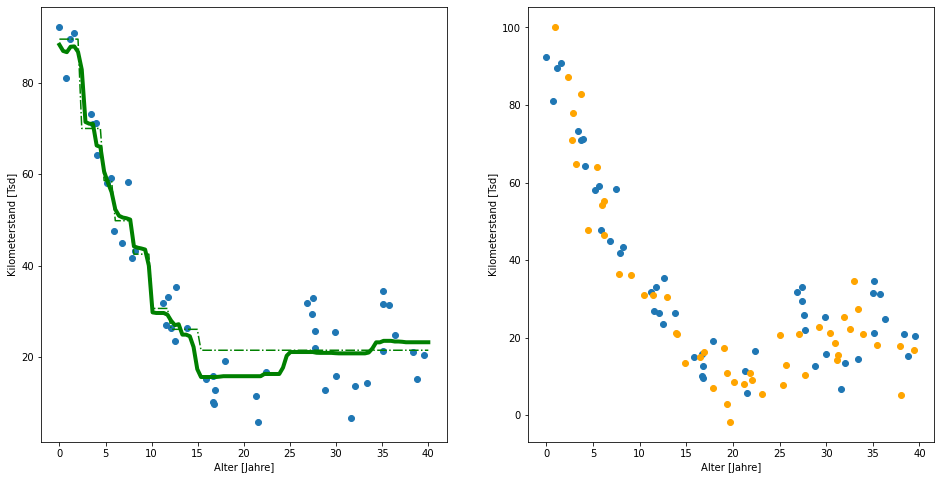

In [13]:
# TODO: Modell visualisieren
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)

plt.scatter(X_train, y_train)
x_vis = np.linspace(0, 40, 100).reshape(-1, 1)

tree_index = 10

plt.plot(x_vis, rf_regressor.predict(x_vis), color="green", lw=4, linestyle="-")
plt.plot(x_vis, rf_regressor[tree_index].predict(x_vis), color="green", linestyle="-.")

plt.xlabel("Alter [Jahre]")
plt.ylabel("Kilometerstand [Tsd]")

plt.subplot(1, 2, 2)
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, color="orange")
plt.xlabel("Alter [Jahre]")
plt.ylabel("Kilometerstand [Tsd]");


## 3. Gradient Boosting

Gradient Boosting ist die zweite der Erweiterungen des Decision Trees. Sie beruht auf der Idee des **Boostings**: die Kombination vieler einfacher Modelle - auch genannt *weak learners* - zu einem starken Modell. Dies geschieht über die sequentielle Fehlerkorrektur. Decision Trees eignen sich sehr gut als *weak learners* weil sie schnell zu trainieren sind. Typischerweise hat jeder Decision Tree im **Boosting** eine sehr kleine Tiefe von 3-5. Manchmal sogar nur die Tiefe 1.

Das Gradient Boosting hat ingesamt drei sehr wichtige und sensitive Hyperparameter:
- `n_estimators`
- `max_depth`
- `learning_rate`

Eventuell müssen alle diese Hyperparamter getunt werden.

Den Effekt der Hyperparameter kann mit in folgender interaktiver Graphik verstehen lernen:

In [25]:
%matplotlib widget
import utils_boosting

X_train, y_train = utils_boosting.generate_data(n_samples=50, random_state=2)
X_test, y_test = utils_boosting.generate_data(n_samples=200, random_state=5)

interactive_plot, ui = utils_boosting.get_interactive_boosting(
    X_train, y_train, X_test, y_test, max_depth=3)
display(interactive_plot, ui)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Output()

### 3.1. Gradient Boosting für Regressionen

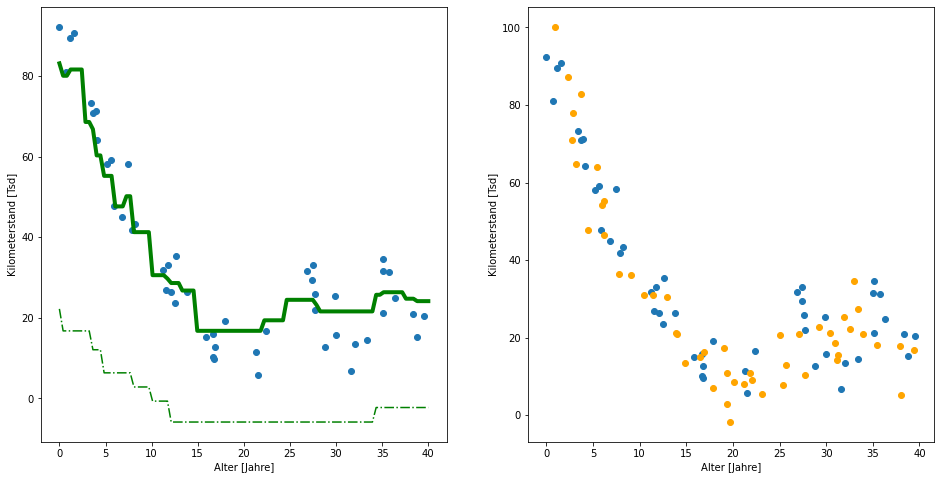

In [19]:
# TODO: Einlesen der Daten `toy_auto_data_A.csv` und `toy_auto_data_test.csv`
data = pd.read_csv("../data/toy_automobile/toy_auto_data_A.csv")
test_data = pd.read_csv("../data/toy_automobile/toy_auto_data_test.csv")

X_train = data.iloc[:, [0]].values
y_train = data.iloc[:, 1].values

X_test = test_data.iloc[:, [0]].values
y_test = test_data.iloc[:, 1].values

# TODO: Modell trainieren
boosting_regressor = GradientBoostingRegressor(n_estimators=20, learning_rate=0.1)
boosting_regressor.fit(X_train, y_train)

# TODO: Modell visualisieren
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)

plt.scatter(X_train, y_train)
x_vis = np.linspace(0, 40, 100).reshape(-1, 1)

tree_index = 10

plt.plot(x_vis, boosting_regressor.predict(x_vis), color="green", lw=4, linestyle="-")
plt.plot(x_vis, boosting_regressor[tree_index][0].predict(x_vis), color="green", linestyle="-.")

plt.xlabel("Alter [Jahre]")
plt.ylabel("Kilometerstand [Tsd]")

plt.subplot(1, 2, 2)
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, color="orange")
plt.xlabel("Alter [Jahre]")
plt.ylabel("Kilometerstand [Tsd]");

### 3.2. Gradient Boosting für Klassifikationen

1.0
0.94


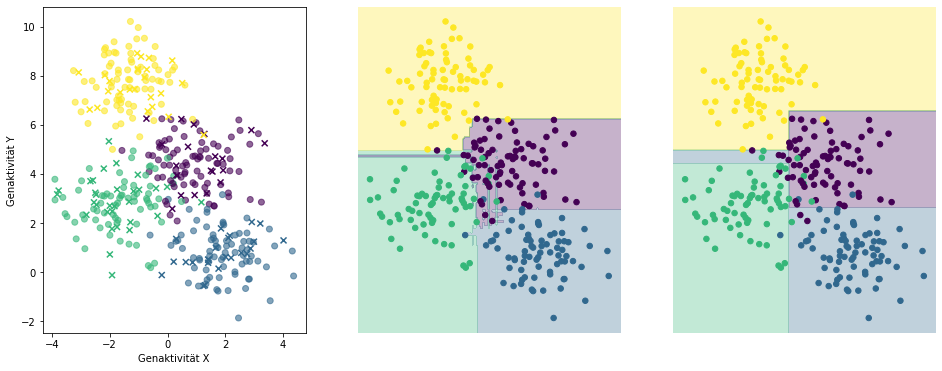

In [14]:
# TODO: Einlesen der Daten `toy_gene_data.csv`
data = pd.read_csv("../data/toy_gene_data.csv")

# TODO: Daten verarbeiten
data["Phänotyp"] = data["Phänotyp"].replace({"A": 0, "B": 1, "C": 2, "D": 3})

# TODO: Aufspalten der Daten in Trainings- und Testdaten
X = data.iloc[:, 0:2].values
y = data.iloc[:, 2].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)


# TODO: Modell trainieren
boosting = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1)
boosting.fit(X_train, y_train)

# TODO: Modell evaluieren
y_pred_train = boosting.predict(X_train)
y_pred_test = boosting.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(accuracy_train)
print(accuracy_test)


# TODO: Visualisieren der Daten
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, marker="x")
plt.xlabel("Genaktivität X")
plt.ylabel("Genaktivität Y")

plt.subplot(1, 3, 2)
utils_viz.visualize_classifier(boosting, X_train, y_train, cmap="viridis")

plt.subplot(1, 3, 3)
utils_viz.visualize_classifier(boosting[10][0], X_train, y_train, cmap="viridis")